In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.inspection import PartialDependenceDisplay

# Use PyALE for ALE plots as specified
from PyALE import ale 

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dataset Loaded!")
print("Features shape:", X.shape)

Dataset Loaded!
Features shape: (569, 30)


In [3]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

print("Top 5 Features by Importance:")
print(importances_sorted.head() * 100)
print("\nModerately Important Features:")
print(importances_sorted[10:15] * 100)

# 2 Highly important features: 'worst perimeter', 'worst concave points'
# 1 Moderately important feature: 'mean texture'
high_imp_1 = 'worst perimeter'
high_imp_2 = 'worst concave points'
mod_imp = 'mean texture'

selected_features = [high_imp_1, high_imp_2, mod_imp]
print(f"\nSelected Features: {selected_features}") #

Top 5 Features by Importance:
worst area              15.389236
worst concave points    14.466327
mean concave points     10.620999
worst radius             7.798688
mean concavity           6.800084
dtype: float64

Moderately Important Features:
area error           2.240696
worst texture        2.174901
worst compactness    2.026604
radius error         2.013892
mean compactness     1.394433
dtype: float64

Selected Features: ['worst perimeter', 'worst concave points', 'mean texture']


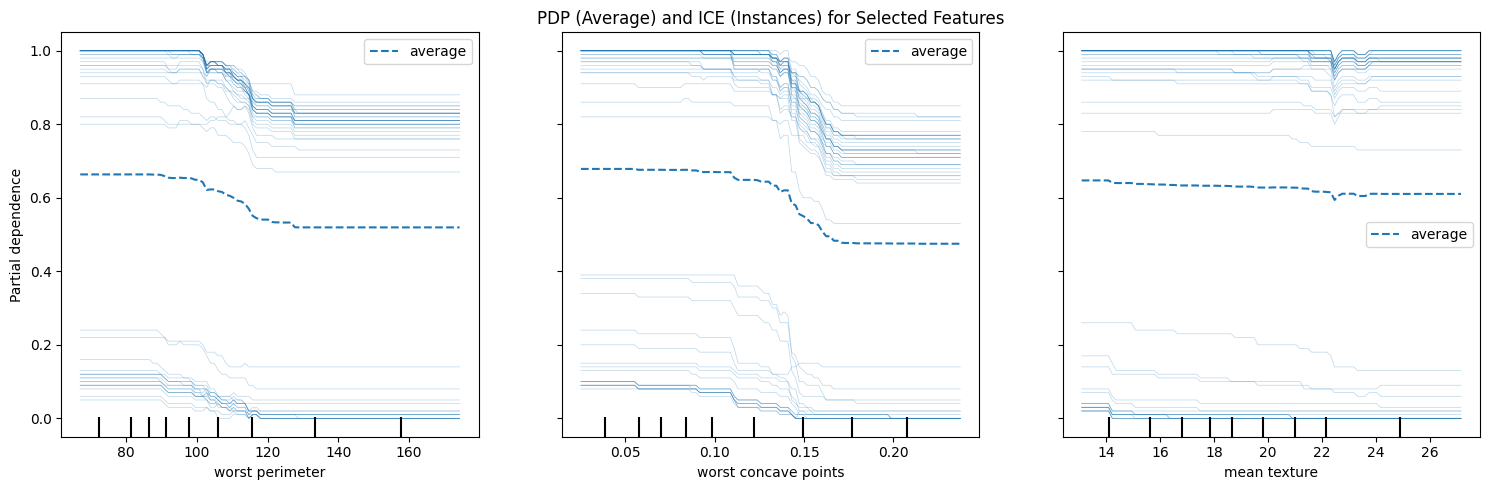

In [4]:
# Using average for PDP and plotting instances for ICE as requested.
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title("PDP (Average) and ICE (Instances) for Selected Features")

# kind='both' plots both the ICE curves (instances) and the PDP (average)
# [cite: 20]
disp = PartialDependenceDisplay.from_estimator(
    rf_model, 
    X_train, 
    features=selected_features, 
    kind='both', 
    subsample=50, # Subsampling instances to make the plot readable
    random_state=42,
    ax=ax
)
plt.tight_layout()
plt.show()

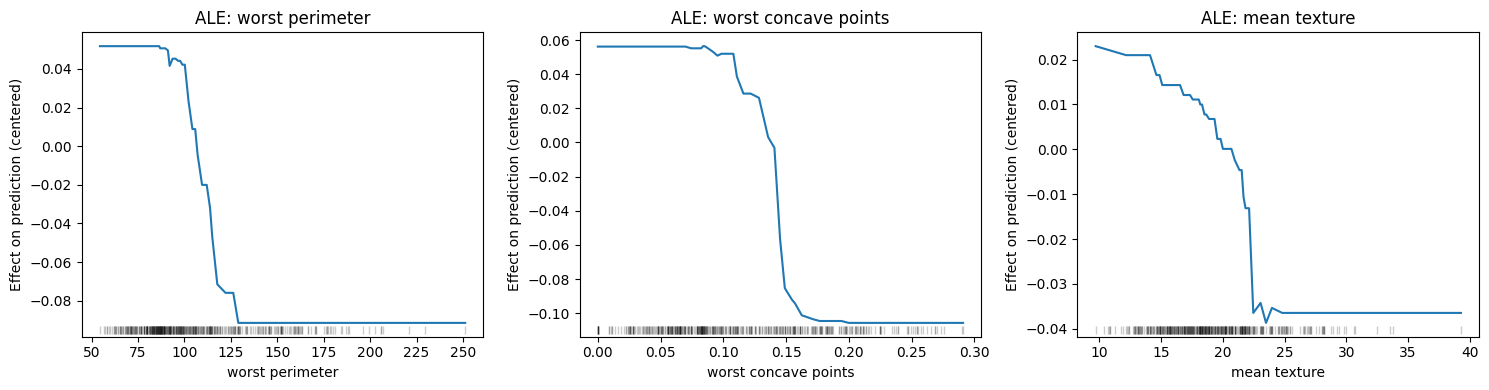

In [9]:
class ProbWrapper:
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]

prob_rf_model = ProbWrapper(rf_model)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, feature in enumerate(selected_features):
    ale_eff = ale(
        X=X_train, 
        model=prob_rf_model, 
        feature=[feature], 
        feature_type='continuous', 
        grid_size=50, 
        include_CI=False, 
        plot=True,
        fig=fig,
        ax=axes[i]
    )
    axes[i].set_title(f"ALE: {feature}")

plt.tight_layout()
plt.show()

Correlation between mean radius and mean perimeter:
                 mean radius  mean perimeter
mean radius         1.00000         0.99785
mean perimeter      0.99785         1.00000


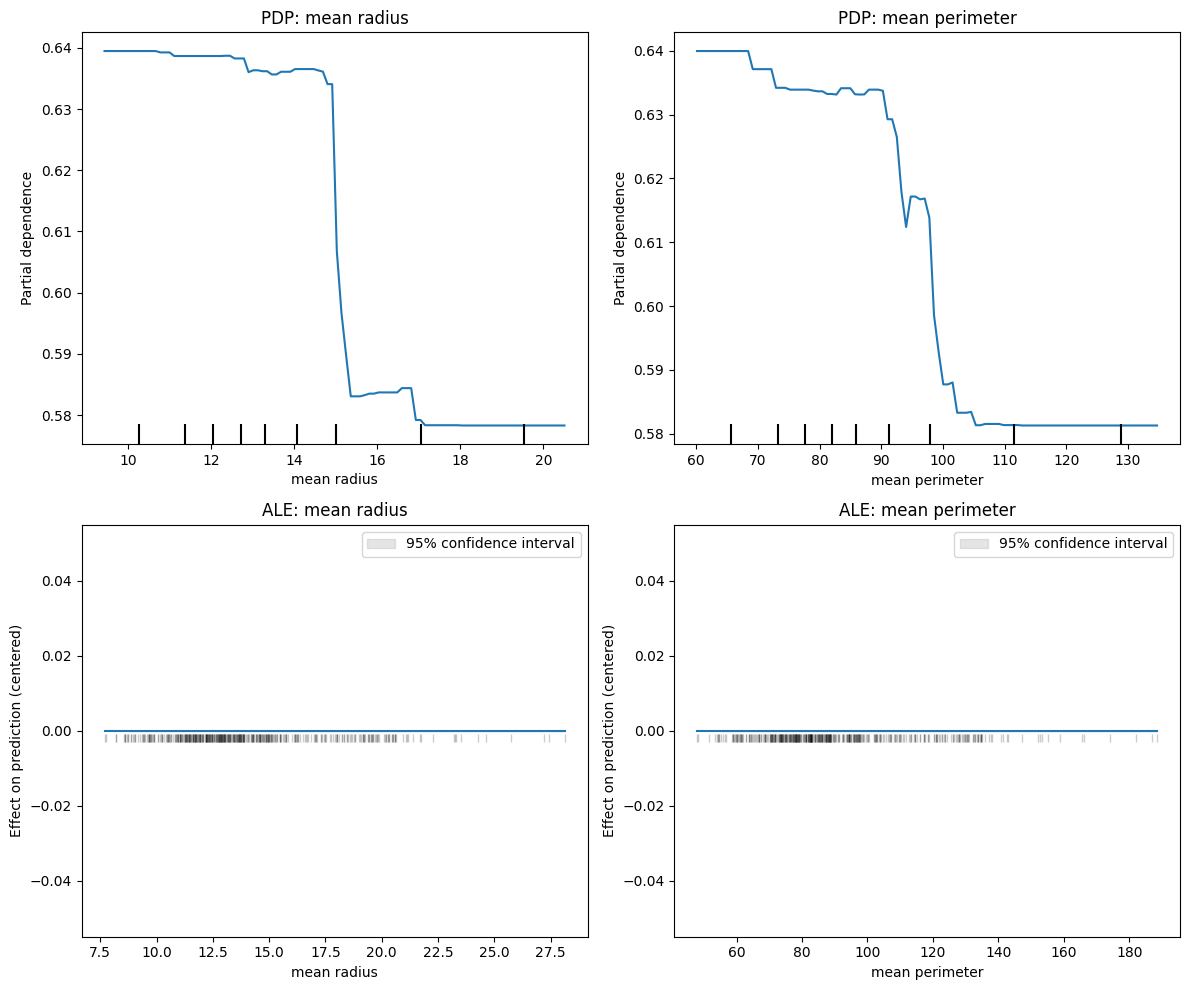

In [6]:
corr_features = ['mean radius', 'mean perimeter']
print(f"Correlation between {corr_features[0]} and {corr_features[1]}:\n", 
      X_train[corr_features].corr())

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# PDPs for correlated features
PartialDependenceDisplay.from_estimator(rf_model, X_train, features=[corr_features[0]], kind='average', ax=axes[0, 0])
PartialDependenceDisplay.from_estimator(rf_model, X_train, features=[corr_features[1]], kind='average', ax=axes[0, 1])
axes[0,0].set_title(f"PDP: {corr_features[0]}")
axes[0,1].set_title(f"PDP: {corr_features[1]}")

# ALEs for correlated features
ale(X=X_train, model=rf_model, feature=[corr_features[0]], feature_type='continuous', grid_size=50, plot=True, fig=fig, ax=axes[1, 0])
ale(X=X_train, model=rf_model, feature=[corr_features[1]], feature_type='continuous', grid_size=50, plot=True, fig=fig, ax=axes[1, 1])
axes[1,0].set_title(f"ALE: {corr_features[0]}")
axes[1,1].set_title(f"ALE: {corr_features[1]}")

plt.tight_layout()
plt.show()

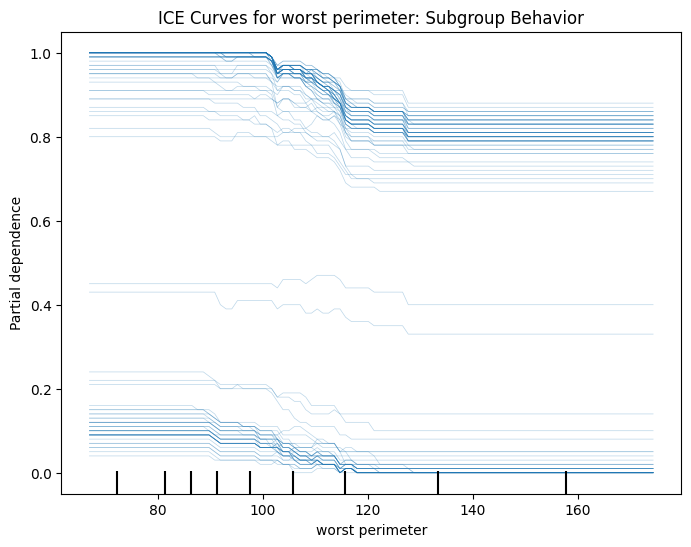

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

PartialDependenceDisplay.from_estimator(
    rf_model, 
    X_train, 
    features=[high_imp_1], 
    kind='individual', 
    subsample=100, 
    random_state=42,
    ax=ax
)

ax.set_title(f"ICE Curves for {high_imp_1}: Subgroup Behavior")
plt.show()

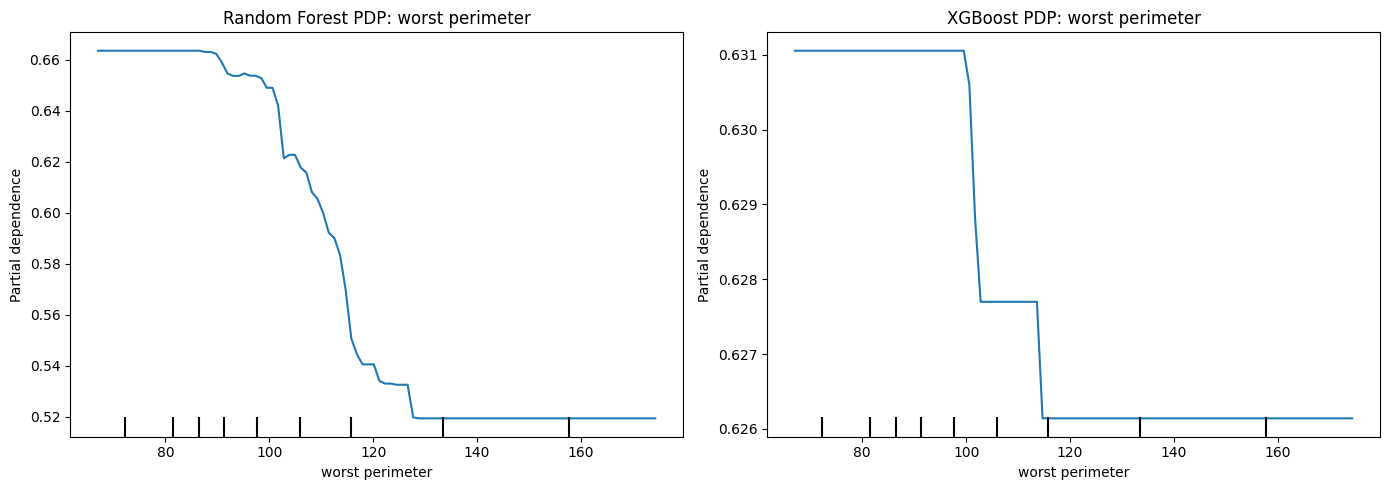

In [8]:
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PDP for Random Forest
PartialDependenceDisplay.from_estimator(
    rf_model, X_train, features=[high_imp_1], kind='average', ax=axes[0]
)
axes[0].set_title(f"Random Forest PDP: {high_imp_1}")

# PDP for XGBoost
PartialDependenceDisplay.from_estimator(
    xgb_model, X_train, features=[high_imp_1], kind='average', ax=axes[1]
)
axes[1].set_title(f"XGBoost PDP: {high_imp_1}")

plt.tight_layout()
plt.show()